In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt


In [2]:
# Load your dataset
data = pd.read_csv('cllc_converter_data.csv')  # Adjust path as necessary


In [3]:
data

,time,voltage,current,frequency
0,0,100.993428,11.899355,49.662411
1,1,99.823470,11.424534,49.957740
2,2,101.495364,10.559230,49.663781
3,3,103.346015,9.852163,49.935989
4,4,99.931587,11.196624,49.173121
...,...,...,...,...
995,995,94.423748,11.318743,51.449506
996,996,98.495053,10.213346,51.518219
997,997,96.095606,9.349171,50.746728
998,998,93.586322,10.059065,51.512653


In [4]:
# data.drop(columns="Unnamed: 0", inplace=True)

In [5]:
data

,time,voltage,current,frequency
0,0,100.993428,11.899355,49.662411
1,1,99.823470,11.424534,49.957740
2,2,101.495364,10.559230,49.663781
3,3,103.346015,9.852163,49.935989
4,4,99.931587,11.196624,49.173121
...,...,...,...,...
995,995,94.423748,11.318743,51.449506
996,996,98.495053,10.213346,51.518219
997,997,96.095606,9.349171,50.746728
998,998,93.586322,10.059065,51.512653


In [ ]:
# # Use MinMaxScaler to normalize the data
scal1 = (data['voltage'][0] - data['voltage'].to_numpy().min())/(data['voltage'].to_numpy().max() - data['voltage'].to_numpy().min())
scal1

0.5032760933918541

In [9]:
# Use MinMaxScaler to normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['voltage', 'current', 'frequency']].values)  # Adjust features as needed

# In case sequence_length=3 

In [13]:
scaled_data[0:4]

array([[0.50327609, 0.73837726, 0.43100795],
       [0.46552505, 0.66843588, 0.47489744],
       [0.51947204, 0.54097647, 0.43121157],
       [0.57918698, 0.43682532, 0.47166502]])

In [ ]:
# X[0] = scaled_data[0:3] 
scaled_data[0:3]

array([[0.50327609, 0.73837726, 0.43100795],
       [0.46552505, 0.66843588, 0.47489744],
       [0.51947204, 0.54097647, 0.43121157]])

In [ ]:
# Y[0] = scaled_data[3,2]
scaled_data[3,2]

0.47166502271297617

In [36]:
# Prepare the data for LSTM
def create_sequences(data, sequence_length=50):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length, 0])  # Assuming voltage is the target (adjust if needed)
    return np.array(X), np.array(y)


In [38]:
sequence_length = 50  # Example: Use last 50 time steps to predict the next
X, y = create_sequences(scaled_data)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Reshape the data to match LSTM input shape (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))


In [6]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))  # Predicting the next voltage value

In [7]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10800     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10,851
Trainable params: 10,851
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
24/24 [==============================] - 0s 13ms/step - loss: 0.0048 - val_loss: 0.0057
Epoch 2/10
24/24 [==============================] - 0s 10ms/step - loss: 0.0048 - val_loss: 0.0046
Epoch 3/10
24/24 [==============================] - 0s 8ms/step - loss: 0.0048 - val_loss: 0.0048
Epoch 4/10
24/24 [==============================] - 0s 8ms/step - loss: 0.0047 - val_loss: 0.0045
Epoch 5/10
24/24 [==============================] - 0s 7ms/step - loss: 0.0047 - val_loss: 0.0044
Epoch 6/10
24/24 [==============================] - 0s 7ms/step - loss: 0.0047 - val_loss: 0.0048
Epoch 7/10
24/24 [==============================] - 0s 7ms/step - loss: 0.0047 - val_loss: 0.0043
Epoch 8/10
24/24 [==============================] - 0s 7ms/step - loss: 0.0046 - val_loss: 0.0052
Epoch 9/10
24/24 [==============================] - 0s 7ms/step - loss: 0.0047 - val_loss: 0.0045
Epoch 10/10
24/24 [==============================] - 0s 8ms/step - loss: 0.0048 - val_loss: 0.0049


In [11]:
# Make predictions
predictions = model.predict(X_test)

6/6 [==============================] - 0s 5ms/step


In [12]:
# Reverse the scaling of predictions
predictions_rescaled = scaler.inverse_transform(np.hstack((predictions, np.zeros((predictions.shape[0], X_test.shape[2] - 1)))))

In [13]:
# Evaluate the regression model using MAE, MSE, and R2
mae = mean_absolute_error(y_test, predictions_rescaled[:, 0])
mse = mean_squared_error(y_test, predictions_rescaled[:, 0])
r2 = r2_score(y_test, predictions_rescaled[:, 0])

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

Mean Absolute Error: 103.50942919255574
Mean Squared Error: 10732.717289996972
R^2 Score: -372413.4870404404


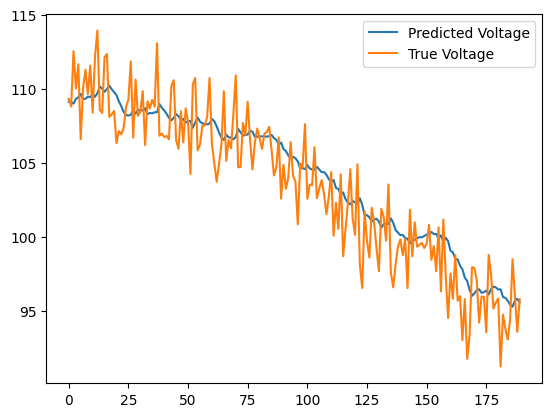

In [14]:
# Plot the results
plt.plot(predictions_rescaled[:, 0], label='Predicted Voltage')
plt.plot(scaler.inverse_transform((np.hstack((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], X_test.shape[2] - 1))))))[:, 0], label='True Voltage')
plt.legend()
plt.show()

In [15]:
# Save Model
model.save('my_lstm_model.keras')
